In [158]:
import numpy as np
import choix
import opt_fair
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from matplotlib import colors
import scipy.sparse as sp
import pandas as pd

In [159]:
size = 100 #number of items
min_size = 30 
maj_size = size - min_size
num_reviewers = 50 #number of reviewers
pair_per_reviewer = 100 #number of pairs evaluated per reviewer

In [160]:
#init original scores
np.random.seed(30)
std = 5
original = np.random.normal(0,std ,size = size)
classes = [0] * maj_size + [1] * min_size

In [161]:
def _matrix_of_comparisons(size,l, reg = 1):
    ''' Input: 
    size = the number of items
    l = the list of pairwise comparisons (a list of pairs, with the first of the pair is the one that has been preferred)
        Output:
    a (size x size) matrix, where a_ij represents the fraction of times object j has been preferred to
    object i'''
    
    A = np.zeros((size,size))
    for i,j in l:
        A[j,i] += 1 #i won
    
    B = np.zeros((size,size)) 
    for i in range(size):
        for j in range(size):
            if A[i,j]!=0:
                B[i,j] = A[i,j]/(A[i,j] + A[j,i])
                
    return B + reg * (np.ones((size,size)) - np.eye(size))
    

In [162]:
rep = 5
mean_bias_M = [x/2 for x in [0,1,2,3,4,5,6,7,8,9,10]]
annot_bt_M = np.zeros((len(mean_bias_M),rep))
bt_M = np.zeros((len(mean_bias_M),rep))
rank_centrality_M = np.zeros((len(mean_bias_M),rep))
crowd_bt_M = np.zeros((len(mean_bias_M),rep))
factor_bt_M = np.zeros((len(mean_bias_M),rep))
fair_post_M = np.zeros((len(mean_bias_M),rep))


In [163]:
def crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 101, tol = 1e-5, gtol = 1e-5):
    '''x0 is the estimated scores
       y0 is the estimated bias for each reviewer'''
    x0 = np.zeros(size)
    y0 = np.ones(num_reviewers)*0.7
    bounds = [(0, 1)] * len(y0)


    for i in range(iters):

        
        
        # minimize with y fixed and update x
        res_x = minimize(lambda x: pc_with_revs.crowdbt_objective(x, y0), x0,tol = tol,  jac=lambda x: pc_with_revs.crowdbt_gradient_scores(x, y0), options={"gtol": gtol,'maxiter': 1})
        x0 = res_x.x
        
        
        # minimize with x fixed and update y
        res_y = minimize(lambda y: pc_with_revs.crowdbt_objective(x0, y), y0,tol = tol, jac=lambda y: pc_with_revs.crowdbt_gradient_revs(x0, y), bounds=bounds, options={"gtol": gtol,'maxiter': 1})
        y0 = res_y.x


        if res_x.success and res_y.success:
            break
    return x0,y0


In [164]:
def FactorBT_alternate_optim(size, num_reviewers, pc_with_revs, iters = 101, tol = 1e-5, gtol = 1e-5):
    '''x0: is the estimated scores
       y0: is the estimated bias for each reviewer - i.e. gamma/g
       Z0: is the estimated bias for each reviewer - i.e. r 
       '''
    x0 = np.zeros(size)
    y0 = np.ones(num_reviewers)*0.7
    z0 = np.zeros(num_reviewers)
    bounds = [(0, 1)] * len(y0)



    for i in range(iters):

        # minimize with x,z fixed and update y
        res_y = minimize(lambda y: pc_with_revs.FactorBT_objective(x0, y, z0), y0,tol = tol, jac=lambda y: pc_with_revs.FactorBT_gradient_g(x0, y, z0),bounds=bounds, options={"gtol": gtol,'maxiter': 1})
        y0 = res_y.x
        
        res_z = minimize(lambda z: pc_with_revs.FactorBT_objective(x0, y0, z), z0,tol = tol, jac=lambda z: pc_with_revs.FactorBT_gradient_r(x0, y0, z), options={"gtol": gtol,'maxiter': 1})
        z0 = res_z.x

        # minimize with y,z fixed and update x
        res_x = minimize(lambda x: pc_with_revs.FactorBT_objective(x, y0, z0), x0,tol = tol, jac=lambda x: pc_with_revs.FactorBT_gradient_scores(x, y0, z0), options={"gtol": gtol,'maxiter': 1})
        x0 = res_x.x



        if res_x.success and res_y.success:
            break
    return x0,y0,z0




In [165]:
#NOTE FA*IR postproc method work with python 3.7, with other versions you need to download
#the repo locally and an int() on the output of the __hash__ function to fix the error

import sys
sys.path.insert(1,'../../fairsearchcore-python/')
from fairsearchcore import fair
from fairsearchcore.models import FairScoreDoc


In [166]:
fairr = fair.Fair(k=size, p=0.7, alpha=0.15)


In [167]:
def fair_post(scores, classes,fair):
    
    df = pd.DataFrame({
        'Index': np.arange(len(scores)),
        'Scores': scores,
        'Classes': [True if element == 0 else False for element in classes]
    })
    
    df = df.reset_index()[['Index', 'Scores', 'Classes']].sort_values('Scores', ascending=False)
    
    ranking_list = df.to_numpy()
    
    fair_score_list = [FairScoreDoc(entry[0], entry[1], entry[2]) for entry in ranking_list]

    re_ranked_list = fair.re_rank(fair_score_list)

    post_proc = [(len(scores) - i, entry.id, entry.score) for i, entry in enumerate(re_ranked_list)]

    sorted_post_proc = sorted(post_proc, key=lambda x: x[1])

    res = [x[0] for x in sorted_post_proc]

    return res


In [45]:
%%time
np.random.seed(43)

for n in range(rep):
    for i,bias in enumerate(mean_bias_M):
        revs_bias = np.random.normal(loc= bias, scale = 0.1, size=num_reviewers)
        biased_scores = opt_fair._create_matrix_biased_scores(original,revs_bias,classes)
        revs_set =  opt_fair._create_pc_set_for_reviewers(biased_scores,pair_per_reviewer)
        all_pc  = opt_fair._pc_without_reviewers(revs_set)
        
        #BT
        bt_temp = choix.opt_pairwise(size, all_pc, alpha=0, method='Newton-CG', initial_params=None, max_iter=None, tol=1e-05)
        bt_M[i,n],x = stats.kendalltau(bt_temp,original)
        
        #RankCentrality
        A = _matrix_of_comparisons(size,all_pc)
        P = opt_fair._trans_prob(A)
        rank_centrality_temp = np.log(opt_fair._stationary_dist(P))
        rank_centrality_M[i,n],x = stats.kendalltau(rank_centrality_temp,original)

        
        #crowd bt
        pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        crowd_bt_temp,x =  crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        crowd_bt_M[i,n],x = stats.kendalltau(crowd_bt_temp,original)
        
        #Factor bt
        factor_bt_temp,y,z =  FactorBT_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        factor_bt_M[i,n],x = stats.kendalltau(factor_bt_temp,original)
        
        #BARP (our method)
        #pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        annot_bt_temp,annot_bias =  opt_fair._alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        annot_bt_M[i,n],x = stats.kendalltau(annot_bt_temp,original)
        
        #FairPostprocessing (postproc BT)
        fair_post_temp = fair_post(bt_temp, classes, fairr)
        fair_post_M[i,n],x = stats.kendalltau(fair_post_temp,original)
        
        print(n,bias,bt_M[i,n],crowd_bt_M[i,n],factor_bt_M[i,n],annot_bt_M[i,n], rank_centrality_M[i,n], fair_post_M[i,n])

0 0.0 0.9414141414141415 0.9406060606060608 0.9406060606060608 0.9381818181818184 0.9094949494949497 0.9414141414141415
0 0.5 0.9385858585858587 0.9361616161616163 0.9361616161616163 0.9321212121212122 0.9179797979797981 0.9385858585858587
0 1.0 0.9191919191919193 0.9195959595959596 0.9195959595959596 0.9474747474747477 0.8989898989898991 0.9191919191919193
0 1.5 0.8901010101010103 0.8905050505050507 0.8905050505050507 0.933737373737374 0.867878787878788 0.8901010101010103
0 2.0 0.8606060606060607 0.8602020202020203 0.8602020202020203 0.943838383838384 0.8416161616161618 0.8610101010101011
0 2.5 0.838787878787879 0.8371717171717173 0.8371717171717173 0.9434343434343435 0.8165656565656567 0.8416161616161618
0 3.0 0.8141414141414143 0.8133333333333335 0.8133333333333335 0.9240404040404041 0.791919191919192 0.8319191919191921
0 3.5 0.7874747474747477 0.7886868686868688 0.7886868686868688 0.9155555555555558 0.7741414141414142 0.8226262626262627
0 4.0 0.7757575757575759 0.7765656565656567 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


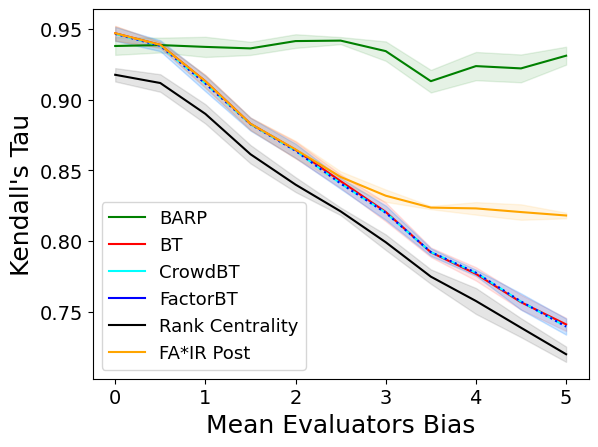

In [106]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.plot(mean_bias_M, np.mean(annot_bt_M, 1), 'green')
plt.fill_between(mean_bias_M, np.mean(annot_bt_M, 1) - np.std(annot_bt_M, 1), np.mean(annot_bt_M, 1) + np.std(annot_bt_M, 1), color='green', alpha=.1)

plt.plot(mean_bias_M, np.mean(bt_M, 1), 'red')
plt.fill_between(mean_bias_M, np.mean(bt_M, 1) - np.std(bt_M, 1), np.mean(bt_M, 1) + np.std(bt_M, 1), color='red', alpha=.1)

plt.plot(mean_bias_M, np.mean(rank_centrality_M, 1), 'black')
plt.fill_between(mean_bias_M, np.mean(rank_centrality_M, 1) - np.std(rank_centrality_M, 1), np.mean(rank_centrality_M, 1) + np.std(rank_centrality_M, 1), color='black', alpha=.1)

plt.plot(mean_bias_M, np.mean(crowd_bt_M, 1), 'cyan', linestyle='--')
plt.fill_between(mean_bias_M, np.mean(crowd_bt_M, 1) - np.std(crowd_bt_M, 1), np.mean(crowd_bt_M, 1) + np.std(crowd_bt_M, 1), color='cyan', alpha=.1)

plt.plot(mean_bias_M, np.mean(factor_bt_M, 1), 'b', linestyle=':')
plt.fill_between(mean_bias_M, np.mean(factor_bt_M, 1) - np.std(factor_bt_M, 1), np.mean(factor_bt_M, 1) + np.std(factor_bt_M, 1), color='b', alpha=.1)

plt.plot(mean_bias_M, np.mean(fair_post_M, 1), 'orange')
plt.fill_between(mean_bias_M, np.mean(fair_post_M, 1) - np.std(fair_post_M, 1), np.mean(fair_post_M, 1) + np.std(fair_post_M, 1), color='orange', alpha=.1)

plt.xlabel('Mean Evaluators Bias')
plt.ylabel("Kendall's Tau")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Mean Evaluators Bias', fontsize=18)
plt.ylabel("Kendall's Tau", fontsize=18)
plt.legend(fontsize=16)


legend_lines = [
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='red'),
    Line2D([0], [0], color='cyan'),
    Line2D([0], [0], color='b'),
    Line2D([0], [0], color='black'),
    Line2D([0], [0], color='orange')  
]
plt.legend(legend_lines, ['BARP', 'BT', 'CrowdBT', 'FactorBT', 'Rank Centrality',  'FA*IR Post'], fontsize=13)


plt.savefig("../plots/method_comparisons.pdf", bbox_inches="tight")

plt.show()



In [68]:
#changing std of annotators
rep = 5
mean_bias_S = [x for x in [0,1,2,3,4,5,6,7,8,9,10]]
annot_bt_S = np.zeros((len(mean_bias_S), rep))
bt_S = np.zeros((len(mean_bias_S), rep))
rank_centrality_S = np.zeros((len(mean_bias_S), rep))
crowd_bt_S = np.zeros((len(mean_bias_S), rep))
factor_bt_S = np.zeros((len(mean_bias_S), rep))
fair_post_S = np.zeros((len(mean_bias_S), rep))



In [69]:
%%time
np.random.seed(43)

for n in range(rep):
    for i,bias in enumerate(mean_bias_S):
        revs_bias = np.random.normal(loc= 0, scale = bias, size=num_reviewers)
        biased_scores = opt_fair._create_matrix_biased_scores(original,revs_bias,classes)
        revs_set =  opt_fair._create_pc_set_for_reviewers(biased_scores,pair_per_reviewer)
        all_pc  = opt_fair._pc_without_reviewers(revs_set)
        
        #BT
        bt_temp = choix.opt_pairwise(size, all_pc, alpha=0, method='Newton-CG', initial_params=None, max_iter=None, tol=1e-05)
        bt_S[i,n],x = stats.kendalltau(bt_temp,original)
        
        #RankCentrality
        A = _matrix_of_comparisons(size,all_pc)
        P = opt_fair._trans_prob(A)
        rank_centrality_temp = np.log(opt_fair._stationary_dist(P))
        rank_centrality_S[i,n],x = stats.kendalltau(rank_centrality_temp,original)

        
        #crowd bt
        pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        crowd_bt_temp,x =  crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        crowd_bt_S[i,n],x = stats.kendalltau(crowd_bt_temp,original)
        
        #Factor bt
        factor_bt_temp,y,z =  FactorBT_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        factor_bt_S[i,n],x = stats.kendalltau(factor_bt_temp,original)
        
        #BARP (our method)
        #pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        annot_bt_temp,annot_bias =  opt_fair._alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        annot_bt_S[i,n],x = stats.kendalltau(annot_bt_temp,original)
        
        #FairPostprocessing (postproc BT)
        fair_post_temp = fair_post(bt_temp, classes, fairr)
        fair_post_S[i,n],x = stats.kendalltau(fair_post_temp,original)
        
        print(n,bias,bt_S[i,n],crowd_bt_S[i,n],factor_bt_S[i,n],annot_bt_S[i,n], rank_centrality_S[i,n], fair_post_S[i,n])


0 0 0.943838383838384 0.9414141414141415 0.9414141414141415 0.9414141414141415 0.9086868686868688 0.943838383838384
0 1 0.9450505050505053 0.9426262626262627 0.9426262626262627 0.9406060606060608 0.9200000000000003 0.9450505050505053
0 2 0.9462626262626265 0.9470707070707072 0.9470707070707072 0.9523232323232325 0.9135353535353536 0.9462626262626265
0 3 0.93979797979798 0.9406060606060608 0.9406060606060608 0.9357575757575758 0.9098989898989901 0.93979797979798
0 4 0.9357575757575758 0.924848484848485 0.924848484848485 0.9454545454545457 0.9151515151515153 0.9357575757575758
0 5 0.8929292929292931 0.86989898989899 0.86989898989899 0.9385858585858587 0.8674747474747476 0.8929292929292931
0 6 0.9171717171717173 0.9191919191919193 0.9191919191919193 0.9498989898989901 0.8892929292929294 0.9171717171717173
0 7 0.9054545454545456 0.8779797979797982 0.8779797979797982 0.9252525252525253 0.8812121212121213 0.9054545454545456
0 8 0.903838383838384 0.9006060606060607 0.9006060606060607 0.934141

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


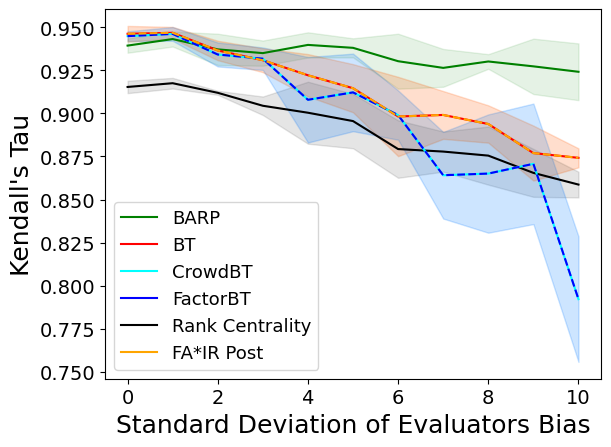

In [105]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.plot(mean_bias_S, np.mean(annot_bt_S, 1), 'green')
plt.fill_between(mean_bias_S, np.mean(annot_bt_S, 1) - np.std(annot_bt_S, 1), np.mean(annot_bt_S, 1) + np.std(annot_bt_S, 1), color='green', alpha=.1)

plt.plot(mean_bias_S, np.mean(bt_S, 1), 'red')
plt.fill_between(mean_bias_S, np.mean(bt_S, 1) - np.std(bt_S, 1), np.mean(bt_S, 1) + np.std(bt_S, 1), color='red', alpha=.1)

plt.plot(mean_bias_S, np.mean(rank_centrality_S, 1), 'black')
plt.fill_between(mean_bias_S, np.mean(rank_centrality_S, 1) - np.std(rank_centrality_S, 1), np.mean(rank_centrality_S, 1) + np.std(rank_centrality_S, 1), color='black', alpha=.1)

plt.plot(mean_bias_S, np.mean(crowd_bt_S, 1), 'cyan')
plt.fill_between(mean_bias_S, np.mean(crowd_bt_S, 1) - np.std(crowd_bt_S, 1), np.mean(crowd_bt_S, 1) + np.std(crowd_bt_S, 1), color='cyan', alpha=.1)

plt.plot(mean_bias_S, np.mean(factor_bt_S, 1), 'b', linestyle='--')
plt.fill_between(mean_bias_S, np.mean(factor_bt_S, 1) - np.std(factor_bt_S, 1), np.mean(factor_bt_S, 1) + np.std(factor_bt_S, 1), color='b', alpha=.1)

plt.plot(mean_bias_S, np.mean(fair_post_S, 1), 'orange', linestyle='--')
plt.fill_between(mean_bias_S, np.mean(fair_post_S, 1) - np.std(fair_post_S, 1), np.mean(fair_post_S, 1) + np.std(fair_post_S, 1), color='orange', alpha=.1)

plt.xlabel('Mean Evaluators Bias')
plt.ylabel("Kendall's Tau")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Standard Deviation of Evaluators Bias', fontsize=18)
plt.ylabel("Kendall's Tau", fontsize=18)
plt.legend(fontsize=16)


legend_lines = [
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='red'),
    Line2D([0], [0], color='cyan'),
    Line2D([0], [0], color='b'),
    Line2D([0], [0], color='black'),
    Line2D([0], [0], color='orange')  
]
plt.legend(legend_lines, ['BARP', 'BT', 'CrowdBT', 'FactorBT', 'Rank Centrality',  'FA*IR Post'], fontsize=13)


plt.savefig("../plots/method_comparison_STD.pdf", bbox_inches="tight")

plt.show()


In [238]:
def exposure(x,classes):
    
    classes = np.array(classes)
    # Combine arrays as two columns
    result = np.column_stack((x, classes))
    
    # Shuffle the rows
    np.random.shuffle(result)

    # Order rows based on scores
    ordered_indices = np.argsort(result[:, 0])
    ordered_result = result[ordered_indices]
    
    
    g0 = 0
    g1 = 0

    for i,cl in enumerate(ordered_result[:,1]): #actully classes are in [:,1]
        if ordered_result[i,1] == 0:
            g0 += 1/(np.log2(i+2)+1)
            
        elif ordered_result[i,1] == 1:
            g1 += 1/(np.log2(i+2)+1)
    
    return  g1/np.count_nonzero(classes == 1)  - g0/np.count_nonzero(classes == 0) 

fairrr = fair.Fair(k=size, p=0.3, alpha=0.1) #we just use the minority as disadvantaged here (we could also do the othe way)     

def fair_post(scores, classes,fair):
    
    df = pd.DataFrame({
        'Index': np.arange(len(scores)),
        'Scores': scores,
        'Classes': [False if element == 0 else True for element in classes]
    })
    
    df = df.reset_index()[['Index', 'Scores', 'Classes']].sort_values('Scores', ascending=False)
    
    ranking_list = df.to_numpy()
    
    fair_score_list = [FairScoreDoc(entry[0], entry[1], entry[2]) for entry in ranking_list]

    re_ranked_list = fair.re_rank(fair_score_list)

    post_proc = [(len(scores) - i, entry.id, entry.score) for i, entry in enumerate(re_ranked_list)]

    sorted_post_proc = sorted(post_proc, key=lambda x: x[1])

    res = [x[0] for x in sorted_post_proc]

    return res




In [239]:
rep = 5
mean_bias_E = [-x/2 for x in [0,1,2,3,4,5,6,7,8,9,10]]
annot_bt_E = np.zeros((len(mean_bias_E),rep))
bt_E = np.zeros((len(mean_bias_E),rep))
rank_centrality_E = np.zeros((len(mean_bias_E),rep))
crowd_bt_E = np.zeros((len(mean_bias_E),rep))
factor_bt_E = np.zeros((len(mean_bias_E),rep))
fair_post_E = np.zeros((len(mean_bias_E),rep))

In [240]:
%%time
np.random.seed(50)

for n in range(rep):
    for i,bias in enumerate(mean_bias_E):
        revs_bias = np.random.normal(loc= bias, scale = 0.1, size=num_reviewers)
        biased_scores = opt_fair._create_matrix_biased_scores(original,revs_bias,classes)
        revs_set =  opt_fair._create_pc_set_for_reviewers(biased_scores,pair_per_reviewer)
        all_pc  = opt_fair._pc_without_reviewers(revs_set)
        
        #BT
        bt_temp = choix.opt_pairwise(size, all_pc, alpha=0, method='Newton-CG', initial_params=None, max_iter=None, tol=1e-05)
        bt_E[i,n] = exposure(bt_temp,classes)
        
        #RankCentrality
        A = _matrix_of_comparisons(size,all_pc)
        P = opt_fair._trans_prob(A)
        rank_centrality_temp = np.log(opt_fair._stationary_dist(P))
        rank_centrality_E[i,n] = exposure(rank_centrality_temp,classes)

        
        #crowd bt
        pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        crowd_bt_temp,x =  crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        crowd_bt_E[i,n] = exposure(crowd_bt_temp,classes)
        
        #Factor bt
        factor_bt_temp,y,z =  FactorBT_alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        factor_bt_E[i,n] = exposure(factor_bt_temp,classes)
        
        #BARP (our method)
        #pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)
        annot_bt_temp,annot_bias =  opt_fair._alternate_optim(size, num_reviewers, pc_with_revs, iters = 100)
        annot_bt_E[i,n] = exposure(annot_bt_temp,classes)
        
        #FairPostprocessing (postproc BT)
        fair_post_temp = fair_post(bt_temp, classes, fairrr)
        fair_post_E[i,n] = exposure(fair_post_temp,classes)
        
        print(n,bias,bt_E[i,n],crowd_bt_E[i,n],factor_bt_E[i,n],annot_bt_E[i,n], rank_centrality_E[i,n], fair_post_E[i,n])

0 0.0 -0.00534549916633037 -0.005406125647524573 -0.005276793119880857 -0.0037148550151888393 -0.01741406322939426 -0.00534549916633037
0 -0.5 -0.008372238408254101 -0.008671843960823405 -0.008729164082666052 -0.00856838454801151 -0.016865995367635916 -0.008372238408254101
0 -1.0 -0.006356471118464074 -0.006342822250293978 -0.006468149661468331 -0.00897684618669381 -0.013495777631642863 -0.006372630348174091
0 -1.5 0.0036108730236001085 0.004982862402504923 0.004982862402504923 -0.006865243515939645 -0.002254957754744602 0.003561522490852731
0 -2.0 0.010038862257920361 0.009926345690890431 0.009918648381220252 -0.0006598025016968934 0.011235447009287775 0.0099915124929231
0 -2.5 0.011575259621532802 0.011566245011812054 0.01163710949421104 -0.00265441617179199 0.011327780185045627 0.01137717898676538
0 -3.0 0.017383685993266368 0.015304414988504877 0.015297230989397725 -0.004411206719149852 0.017468636583569702 0.017106878623699473
0 -3.5 0.020482075689383678 0.020441339546170556 0.020

In [241]:
mean_bias_E = [-x for x in mean_bias_E]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


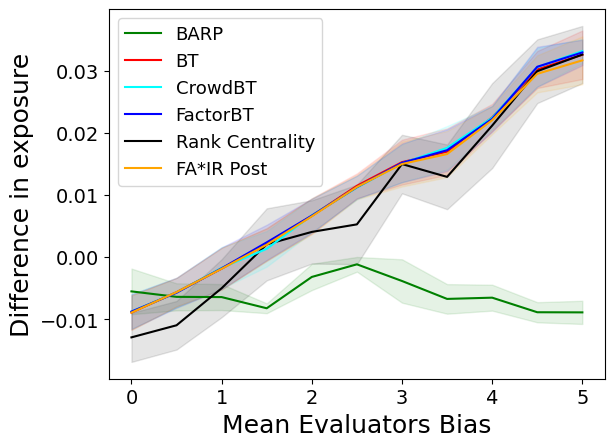

In [242]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.plot(mean_bias_E, np.mean(annot_bt_E, 1), 'green')
plt.fill_between(mean_bias_E, np.mean(annot_bt_E, 1) - np.std(annot_bt_E, 1), np.mean(annot_bt_E, 1) + np.std(annot_bt_E, 1), color='green', alpha=.1)

plt.plot(mean_bias_E, np.mean(bt_E, 1), 'red')
plt.fill_between(mean_bias_E, np.mean(bt_E, 1) - np.std(bt_E, 1), np.mean(bt_E, 1) + np.std(bt_E, 1), color='red', alpha=.1)

plt.plot(mean_bias_E, np.mean(rank_centrality_E, 1), 'black')
plt.fill_between(mean_bias_E, np.mean(rank_centrality_E, 1) - np.std(rank_centrality_E, 1), np.mean(rank_centrality_E, 1) + np.std(rank_centrality_E, 1), color='black', alpha=.1)

plt.plot(mean_bias_E, np.mean(crowd_bt_E, 1), 'cyan')
plt.fill_between(mean_bias_E, np.mean(crowd_bt_E, 1) - np.std(crowd_bt_E, 1), np.mean(crowd_bt_E, 1) + np.std(crowd_bt_E, 1), color='cyan', alpha=.1)

plt.plot(mean_bias_E, np.mean(factor_bt_E, 1), 'b')
plt.fill_between(mean_bias_E, np.mean(factor_bt_E, 1) - np.std(factor_bt_E, 1), np.mean(factor_bt_E, 1) + np.std(factor_bt_E, 1), color='b', alpha=.1)

plt.plot(mean_bias_E, np.mean(fair_post_E, 1), 'orange')
plt.fill_between(mean_bias_E, np.mean(fair_post_E, 1) - np.std(fair_post_E, 1), np.mean(fair_post_E, 1) + np.std(fair_post_E, 1), color='orange', alpha=.1)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Mean Evaluators Bias', fontsize=18)
plt.ylabel("Difference in exposure", fontsize=18)
plt.legend(fontsize=16)


legend_lines = [
    Line2D([0], [0], color='green'),
    Line2D([0], [0], color='red'),
    Line2D([0], [0], color='cyan'),
    Line2D([0], [0], color='b'),
    Line2D([0], [0], color='black'),
    Line2D([0], [0], color='orange')  
]
plt.legend(legend_lines, ['BARP', 'BT', 'CrowdBT', 'FactorBT', 'Rank Centrality',  'FA*IR Post'], fontsize=13)


plt.savefig("../plots/exposure50.pdf", bbox_inches="tight")

plt.show()